Running a Tobit style regression in Stan.

In [1]:
# set up Python
from typing import Iterable
import logging
import numpy as np
import pandas as pd
from plotnine import *
from cmdstanpy import CmdStanModel
from sklearn.linear_model import LinearRegression

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)

In [3]:
# from 
# https://win-vector.com/2024/08/16/post-hoc-adjustment-for-zero-thresholded-linear-models/
def trueprocess(mu: float, N: int =1000):
  x = rng.normal(size=N, loc=mu)
  xnoise = x + 0.1 * rng.normal(size=N)
  y = np.maximum(0.0, xnoise)
  df = pd.DataFrame({'x': x, 'y': y})
  return df

traind = trueprocess(mu=0, N=1000)

lm0 = LinearRegression()
lm0.fit(
    traind.loc[:, ['x']],
    traind.loc[:, 'y'],
)
traind['ypred0'] = np.maximum(0, lm0.predict(traind.loc[:, ['x']]))

traind.head()

,x,y,ypred0
0,1.028857,1.116961,0.927395
1,1.641920,1.557520,1.240285
2,1.146720,0.949668,0.987549
3,-0.973180,0.000000,0.000000
4,-1.392800,0.000000,0.000000


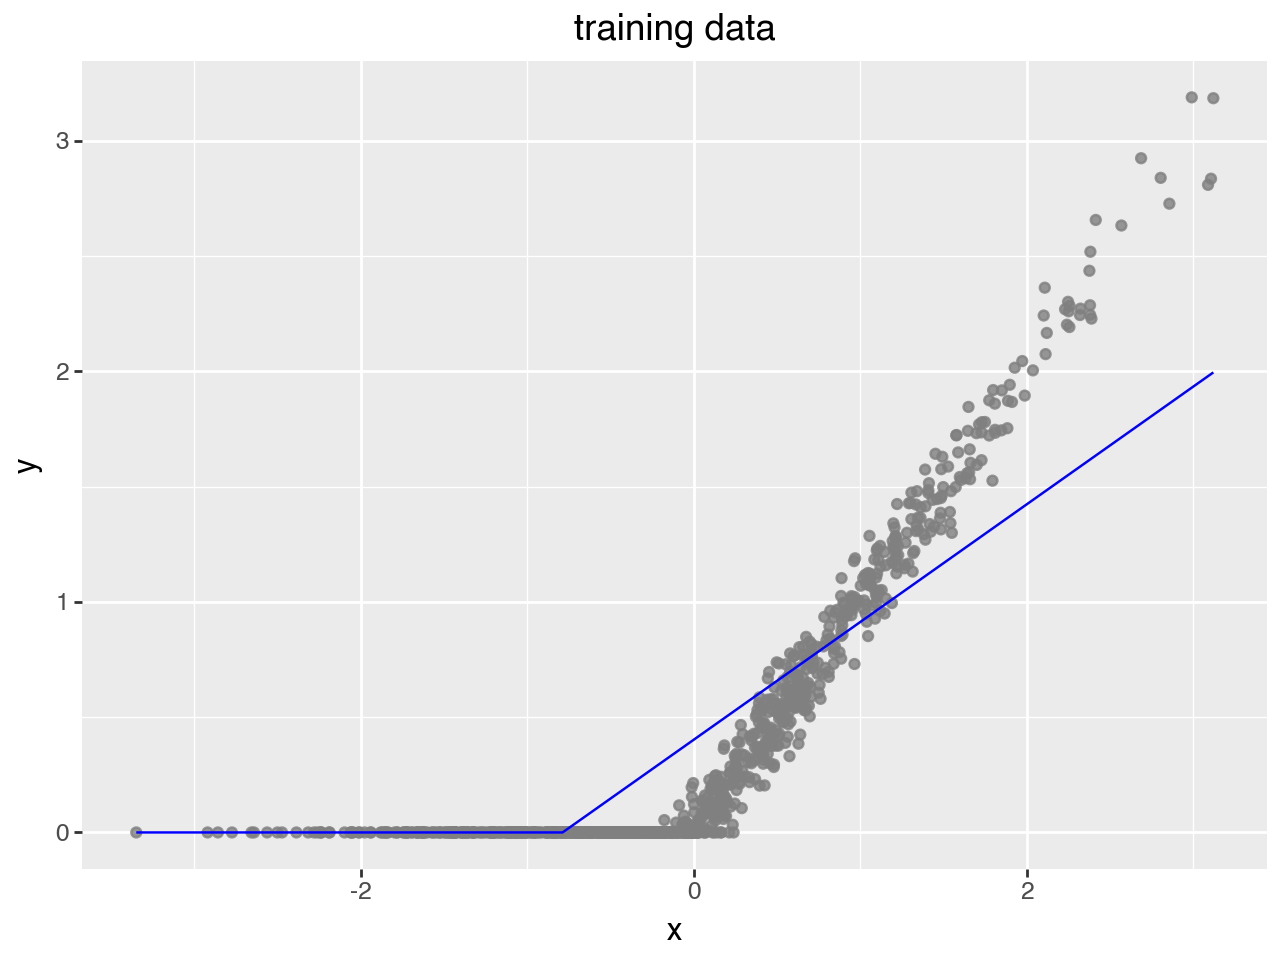

In [4]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) + 
    geom_line(
        mapping=aes(y='ypred0'),
        color="blue") + 
    ggtitle("training data")
)

In [5]:
stan_model_src = """
data {
  int<lower=0> N_positive;   // number of positive observations
  int<lower=0> N_zero;       // number of zeros observations
  vector[N_positive] p_pos;  // observed predictions (to be adjusted to match outcomes)
  vector[N_positive] y_pos;  // observed outcomes
  vector[N_zero] p_zero;     // observed predictions (to be adjusted to match zero outcomes)
}
parameters {
  real a;               // regression slope
  real b;               // regression intercept
  real<lower=0> sigma;  // variance
}
model {
      // basic priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ chi_square(1);
      // Tobit style model structure
  y_pos ~ normal(a * p_pos + b, sigma);
  target += normal_lcdf( 0 | a * p_zero + b, sigma);
}
"""

# target += adds to log probability, and stan maximizes
# see https://mc-stan.org/docs/2_18/reference-manual/increment-log-prob-section.html

In [6]:
# build model
stan_file = 'tobit_tmp.stan'
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)

model

CmdStanModel: name=tobit_tmp
	 stan_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp.stan
	 exe_file=/Users/johnmount/Documents/work/Examples/linear_regression_w_zeros/tobit_tmp
	 compiler_options=stanc_options={}, cpp_options={}

In [7]:
pos_positions = traind['y'] > 0
p_pos = list(traind['ypred0'][pos_positions])
y_pos = list(traind['y'][pos_positions])
p_zero = list(traind['ypred0'][pos_positions == False])

In [8]:
data_str = f"""
{{
"N_positive" : {len(p_pos)},
"N_zero" : {len(p_zero)},
"p_pos" : {p_pos},
"y_pos" : {y_pos},
"p_zero" : {p_zero}
}}
"""

print(data_str)


{
"N_positive" : 495,
"N_zero" : 505,
"p_pos" : [0.9273952572479419, 1.240285300053204, 0.9875490119860799, 0.43659101838467473, 0.8419049707787041, 0.6621703980956077, 1.3262142905428747, 0.7855051069366394, 0.7288110269016412, 1.1598943921681113, 0.42725940814452096, 0.8164727440662793, 0.863193673435833, 0.6157019657136323, 0.541250030522578, 0.43129481061390756, 0.6189840055737297, 0.5171006274868717, 1.2483308057169389, 1.0143270044854864, 1.0204551915777194, 0.726025105992392, 0.7995043539198583, 1.3455480459480862, 0.34370629182330986, 0.6034839774949354, 0.7910605006645575, 1.0837801933330358, 1.0481466845672431, 0.764648645562439, 0.710007794903301, 0.9870170538364601, 0.854945554270133, 0.6154192664188265, 0.4736201790098168, 1.409542545862095, 0.45285735636063135, 0.6769818666008022, 0.740688435505065, 0.9410653926491599, 0.3718706248465237, 0.8058348637747152, 0.49906767462465645, 0.47630461409738584, 1.0292199112353513, 0.8540415458344098, 0.5864778394259422, 0.6226916371

In [9]:
data_file = "tobit_tmp.json"
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)

In [10]:
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
    )

In [11]:
res = fit.draws_pd()

In [12]:
res

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0,835.811,0.967297,0.286992,4.0,15.0,0.0,-834.425,1.96225,-0.793667,0.099337
1,836.388,0.997619,0.286992,3.0,11.0,0.0,-835.052,1.96328,-0.792667,0.101818
2,835.800,0.982630,0.286992,4.0,15.0,0.0,-835.671,1.97702,-0.803445,0.102793
3,835.544,0.903642,0.286992,2.0,7.0,0.0,-833.281,1.97341,-0.797000,0.103455
4,835.030,0.967697,0.286992,3.0,15.0,0.0,-834.733,1.96049,-0.784854,0.105205
...,...,...,...,...,...,...,...,...,...,...
3995,835.407,0.999459,0.268799,4.0,15.0,0.0,-832.773,1.95315,-0.780001,0.103192
3996,835.149,0.718583,0.268799,3.0,13.0,0.0,-831.788,1.96282,-0.786240,0.103735
3997,834.465,0.975354,0.268799,3.0,15.0,0.0,-833.847,1.97959,-0.799798,0.103431
3998,834.678,0.992651,0.268799,4.0,15.0,0.0,-833.770,1.96914,-0.804982,0.100365


In [13]:
a = res['a'].mean()
b = res['b'].mean()

(a, b)

(1.9616370225000002, -0.7921995664999999)

In [14]:
traind['Tobit prediction'] = np.maximum(0, a * traind['ypred0'] + b)

traind

,x,y,ypred0,Tobit prediction
0,1.028857,1.116961,0.927395,1.027013
1,1.641920,1.557520,1.240285,1.640790
2,1.146720,0.949668,0.987549,1.145013
3,-0.973180,0.000000,0.000000,0.000000
4,-1.392800,0.000000,0.000000,0.000000
...,...,...,...,...
995,-1.086436,0.000000,0.000000,0.000000
996,-0.508474,0.000000,0.142785,0.000000
997,0.513753,0.428141,0.664501,0.511310
998,-0.203761,0.000000,0.298302,0.000000


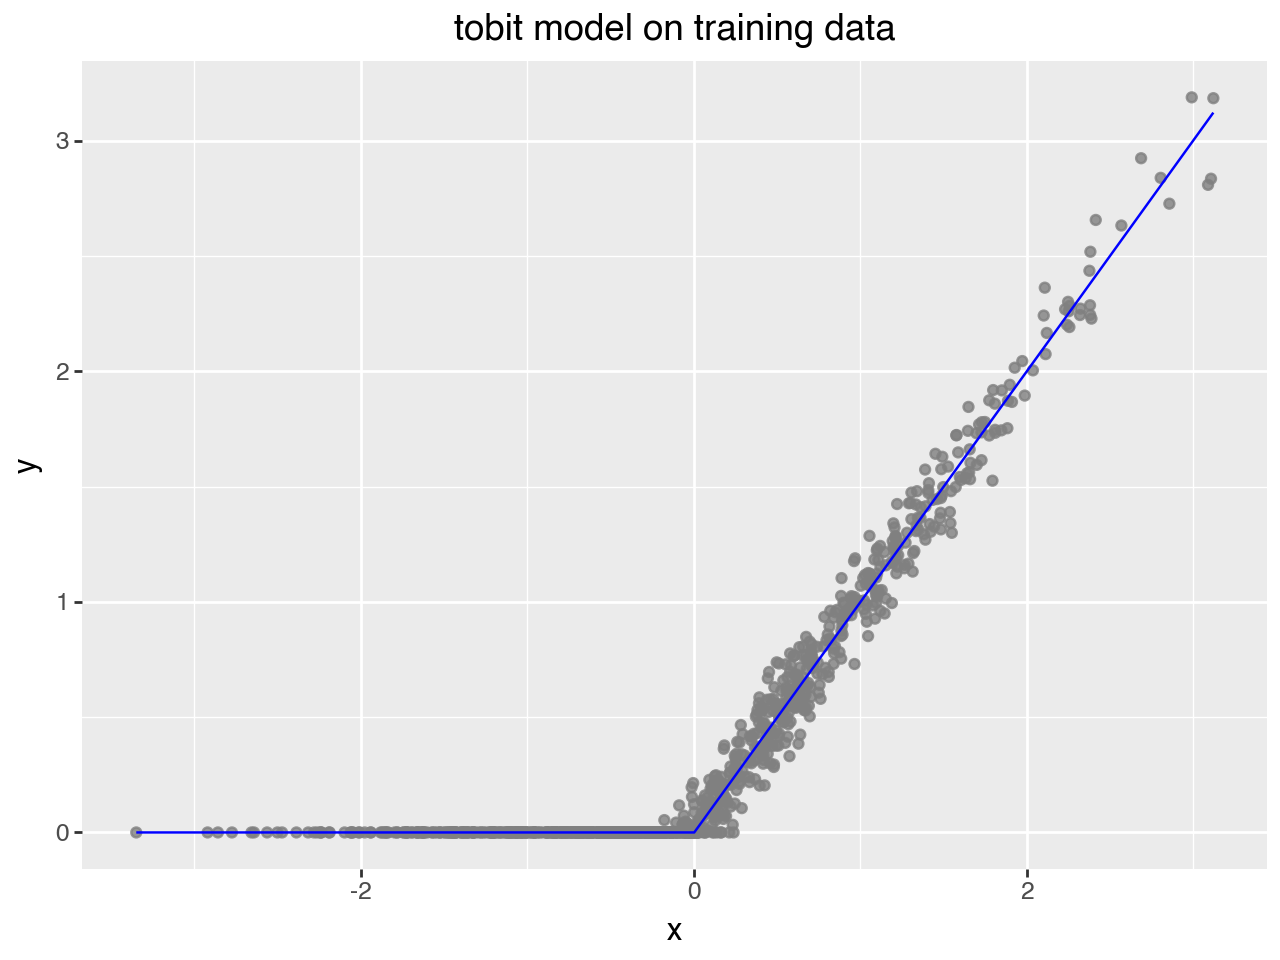

In [15]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='Tobit prediction'),
        color="blue") +
    ggtitle("tobit model on training data")
)

In [16]:
consider_pos_for_lm = traind['ypred0'] > 0  # note: do get a better fit for traind['y'] > 0 cut, but that ignores data near zero.
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm, ['ypred0']],
    traind.loc[consider_pos_for_lm, 'y'],
)
traind['linear prediction (prediction correction cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

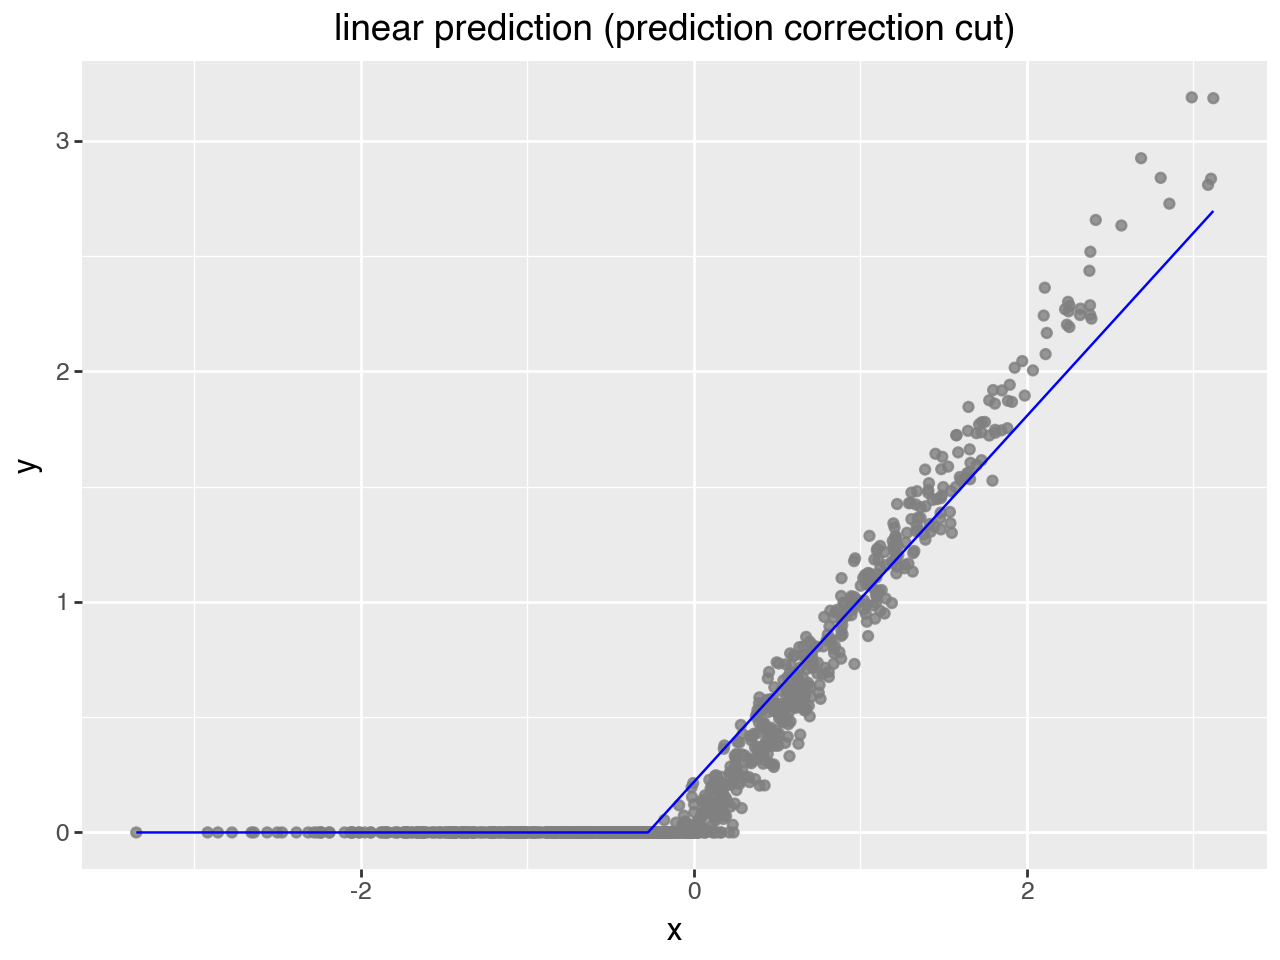

In [17]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (prediction correction cut)'),
        color="blue") +
    ggtitle("linear prediction (prediction correction cut)")
)

In [18]:
(lm.coef_, lm.intercept_)

(array([1.55486759]), -0.40715027318781727)

In [19]:
consider_pos_for_lm_p = traind['y'] > 0
lm = LinearRegression()
lm.fit(
    traind.loc[consider_pos_for_lm_p, ['ypred0']],
    traind.loc[consider_pos_for_lm_p, 'y'],
)
traind['linear prediction (target threshold cut)'] = np.maximum(0, lm.predict(traind.loc[:, ['ypred0']]))

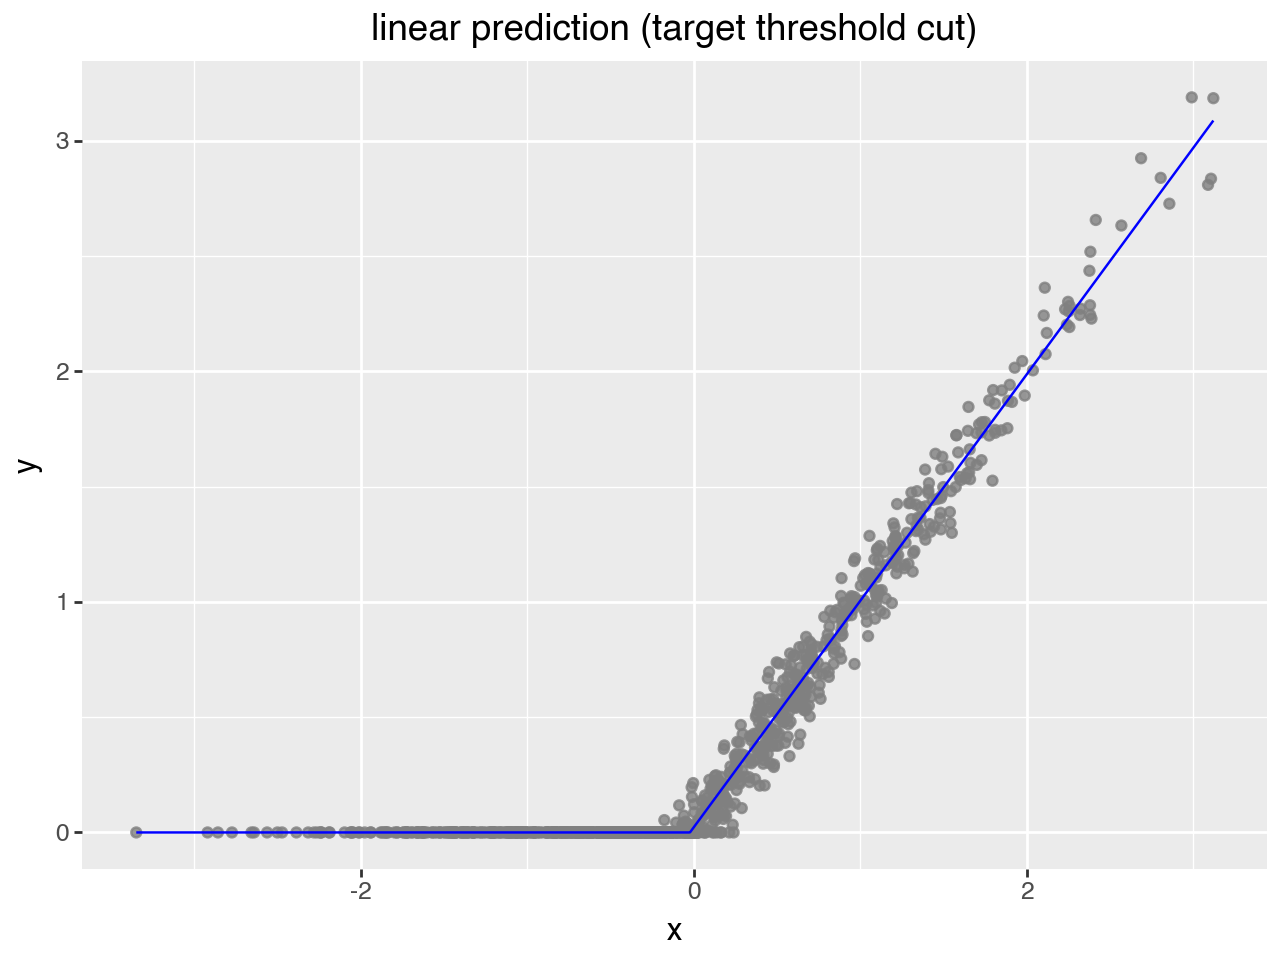

In [20]:
(
    ggplot(
        data=traind, 
        mapping=aes(x='x', y='y')) + 
    geom_point(
        mapping=aes(y='y'),
        color="gray", alpha=0.8) +
    geom_line(
        mapping=aes(y='linear prediction (target threshold cut)'),
        color="blue") +
    ggtitle("linear prediction (target threshold cut)")
)